In [31]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
import tensorflow.keras

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, BatchNormalization, Flatten

from tensorflow.keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed

In [32]:
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model

In [33]:
# load dataset and clean it 
def load_data():
    subjects = pd.read_csv("subjects.csv")
    subjects = subjects[subjects['Label (0 for the null class)']!=0]
    subjects.reset_index(inplace=True)
    subjects.drop(columns=['level_0','Unnamed: 0','index'],inplace=True)
    return subjects

In [34]:
# split the train and test dataset based on subject ID to avoid data leakeage
# then normalize the data
def train_test_split(sample):
    df_train=sample[(sample['subject_number']!=10)].drop(columns=['subject_number','electrocardiogram signal (lead 1)','electrocardiogram signal (lead 2)'])
    df_test=sample[(sample['subject_number']==10)].drop(columns=['subject_number','electrocardiogram signal (lead 1)','electrocardiogram signal (lead 2)'])

    pd.options.mode.chained_assignment = None  # default='warn'

    for i in range(0,21):
        df_train[df_train.columns[i]] = df_train[df_train.columns[i]] / df_train[df_train.columns[i]].max()
    
    for i in range(0,21):
        df_test[df_test.columns[i]] = df_test[df_test.columns[i]] / df_test[df_test.columns[i]].max()
    return df_train, df_test

In [35]:
# reshape the 1D data into a 3D one
# based on time_period (100) and number of features (21 here as it has 21 sensors)
# create overlap within data. Reason:There is some risk that the splitting of the stream of sensor data into windows
# may result in windows that miss the transition of one activity to another. 
def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 21
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs1 = df['acceleration from the chest sensor (X axis)'].values[i: i + time_steps]
        ys1 = df['acceleration from the chest sensor (Y axis)'].values[i: i + time_steps]
        zs1 = df['acceleration from the chest sensor (Z axis)'].values[i: i + time_steps]
        xs2 = df['acceleration from the left-ankle sensor (X axis)'].values[i: i + time_steps]
        ys2 = df['acceleration from the left-ankle sensor (Y axis)'].values[i: i + time_steps]
        zs2 = df['acceleration from the left-ankle sensor (Z axis)'].values[i: i + time_steps]
        xs3 = df['gyro from the left-ankle sensor (X axis)'].values[i: i + time_steps]
        ys3 = df['gyro from the left-ankle sensor (Y axis)'].values[i: i + time_steps]
        zs3 = df['gyro from the left-ankle sensor (Z axis)'].values[i: i + time_steps]
        xs4 = df['magnetometer from the left-ankle sensor (X axis)'].values[i: i + time_steps]
        ys4 = df['magnetometer from the left-ankle sensor (Y axis)'].values[i: i + time_steps]
        zs4 = df['magnetometer from the left-ankle sensor (Z axis)'].values[i: i + time_steps]
        xs5 = df['acceleration from the right-lower-arm sensor (X axis)'].values[i: i + time_steps]
        ys5 = df['acceleration from the right-lower-arm sensor (Y axis)'].values[i: i + time_steps]
        zs5 = df['acceleration from the right-lower-arm sensor (Z axis)'].values[i: i + time_steps]        
        xs6 = df['gyro from the right-lower-arm sensor (X axis)'].values[i: i + time_steps]
        ys6 = df['gyro from the right-lower-arm sensor (Y axis)'].values[i: i + time_steps]
        zs6 = df['gyro from the right-lower-arm sensor (Z axis)'].values[i: i + time_steps]        
        xs7 = df['magnetometer from the right-lower-arm sensor (X axis)'].values[i: i + time_steps]
        ys7 = df['magnetometer from the right-lower-arm sensor (Y axis)'].values[i: i + time_steps]
        zs7 = df['magnetometer from the right-lower-arm sensor (Z axis)'].values[i: i + time_steps]            
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        
        segments.append([xs1, ys1, zs1, xs2, ys2, zs2, xs3, ys3, zs3, xs4, ys4, zs4, xs5, ys5, zs5, xs6, ys6, zs6, xs7, ys7, zs7])
        labels.append(label)


    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [36]:
# re-asign the datatype
# perform one hot encoding of y 
def data_transform(x,y):

    x = x.astype('float32')
    y = y.astype('float32')

    y_hot = np_utils.to_categorical(y, 13)
    y_hot = y_hot[:,1:]
    return x,y_hot

In [37]:
# draw the confustion matrix heatmap
def conf_mat(y_true, y_pred):
    y_pred_true = np.argmax(y_pred, axis=1)+1
    conf_mat = confusion_matrix(y_true, y_pred_true)
    labels =['Standing still','Sitting and relaxing','Lying down',
        'Walking', 'Climbing stairs', 'Waist bends forward',
        'Frontal elevation of arms', 'Knees bending (crouching)',
         'Cycling', 'Jogging', 'Running', 'Jump front & back']

    fig = plt.figure(figsize=(20,20))
    width = np.shape(conf_mat)[1]
    height = np.shape(conf_mat)[0]

    res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
    for i, row in enumerate(conf_mat):
        for j, c in enumerate(row):
            if c>0:
                plt.text(j-.2, i+.1, c, fontsize=16)
            
    cb = fig.colorbar(res)
    plt.title('Confusion Matrix')
    _ = plt.xticks(range(12), [l for l in labels], rotation=90)
    _ = plt.yticks(range(12), [l for l in labels])

In [38]:
# return the classification report
def clf_rep(y_true, y_pred):
    y_pred_true = np.argmax(y_pred, axis=1)+1
    class_report = classification_report(y_true, y_pred_true)
    return class_report

In [39]:
# create the cnn-lstm model
def model_initializer():
    timesteps = 100
    input_dim = 21
    n_classes = 12

    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(None,timesteps,input_dim))))
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(128, activation='relu'))
    model.add(Dense(n_classes, activation='sigmoid'))
    
    return model

In [40]:
# compile and fit the model
def modeling(model, x_train, y_train, batch_size, epochs):
    model.compile(loss='categorical_crossentropy',optimizer='rmsprop',
              metrics=['accuracy'])
    model_history = model.fit(x_train, y_train,
          batch_size=batch_size, epochs=epochs,
          validation_split=0.2,verbose=1)
    return model, model_history

In [41]:
# get the data 
dataset = load_data()
df_train, df_test = train_test_split(dataset)

TIME_PERIODS = 100
STEP_DISTANCE = 2



x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              "Label (0 for the null class)")
x_test, y_test = create_segments_and_labels(df_test,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              "Label (0 for the null class)")

x_train, y_train_hot = data_transform(x_train,y_train)
x_test, y_test_hot = data_transform(x_test,y_test)

In [42]:
# reshape it into 4D 
x_train = x_train.reshape(x_train.shape[0],-1,100,21)
x_test = x_test.reshape(x_test.shape[0],-1,100,21)

In [43]:
# test if the reshape worked
x_test.shape

(16795, 1, 100, 21)

In [44]:
# start modeling
RNN_model = model_initializer()

RNN_model, model_history = modeling(RNN_model, x_train, y_train_hot, 100, 3)

Train on 123762 samples, validate on 30941 samples
Epoch 1/3
123762/123762 [==============================] - 287s 2ms/step - loss: 0.0864 - acc: 0.9689 - val_loss: 0.6770 - val_acc: 0.8602
Epoch 2/3
123762/123762 [==============================] - 258s 2ms/step - loss: 0.0166 - acc: 0.9953 - val_loss: 0.5728 - val_acc: 0.8760
Epoch 3/3
123762/123762 [==============================] - 251s 2ms/step - loss: 0.0121 - acc: 0.9971 - val_loss: 1.0924 - val_acc: 0.8633


In [45]:
# get the model architecture
RNN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_40 (TimeDis (None, 1, 98, 128)        8192      
_________________________________________________________________
time_distributed_41 (TimeDis (None, 1, 96, 128)        49280     
_________________________________________________________________
time_distributed_42 (TimeDis (None, 1, 96, 128)        0         
_________________________________________________________________
time_distributed_43 (TimeDis (None, 1, 48, 128)        0         
_________________________________________________________________
time_distributed_44 (TimeDis (None, 1, 6144)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               3211776   
_________________________________________________________________
dense_8 (Dense)              (None, 12)                1548      
Total para

In [46]:
# make predictions and print the accuracy score
_, accuracy = RNN_model.evaluate(x_test, y_test_hot, batch_size=50, verbose=1)
print(accuracy)

16795/16795 [==============================] - 8s 453us/step
0.9890443582412706


In [126]:
# get the confusion matrix and classification report
y_pred_test = RNN_model.predict(x_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)+1
class_report_test = classification_report(y_test, max_y_pred_test)
conf_mat_test = confusion_matrix(y_test, max_y_pred_test)
print(class_report_test)
print(conf_mat_test)

              precision    recall  f1-score   support

           1       0.98      1.00      0.99      1537
           2       1.00      1.00      1.00      1536
           3       1.00      1.00      1.00      1536
           4       1.00      0.99      0.99      1536
           5       1.00      0.73      0.84      1511
           6       0.98      0.99      0.99      1229
           7       1.00      0.99      0.99      1382
           8       0.78      1.00      0.88      1434
           9       1.00      1.00      1.00      1536
          10       1.00      1.00      1.00      1536
          11       1.00      1.00      1.00      1536
          12       1.00      0.98      0.99       486

    accuracy                           0.97     16795
   macro avg       0.98      0.97      0.97     16795
weighted avg       0.98      0.97      0.97     16795

[[1537    0    0    0    0    0    0    0    0    0    0    0]
 [   1 1535    0    0    0    0    0    0    0    0    0    0]
 [   0 

None
              precision    recall  f1-score   support

           1       0.99      1.00      1.00     13805
           2       1.00      0.89      0.94     13824
           3       1.00      1.00      1.00     13824
           4       1.00      1.00      1.00     13824
           5       0.81      1.00      0.90     13799
           6       1.00      0.97      0.98     12929
           7       1.00      0.99      0.99     13336
           8       0.93      0.89      0.91     13236
           9       1.00      0.94      0.97     13824
          10       1.00      1.00      1.00     13824
          11       1.00      1.00      1.00     13824
          12       1.00      1.00      1.00      4654

    accuracy                           0.97    154703
   macro avg       0.98      0.97      0.97    154703
weighted avg       0.98      0.97      0.97    154703

None
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1537
           2  

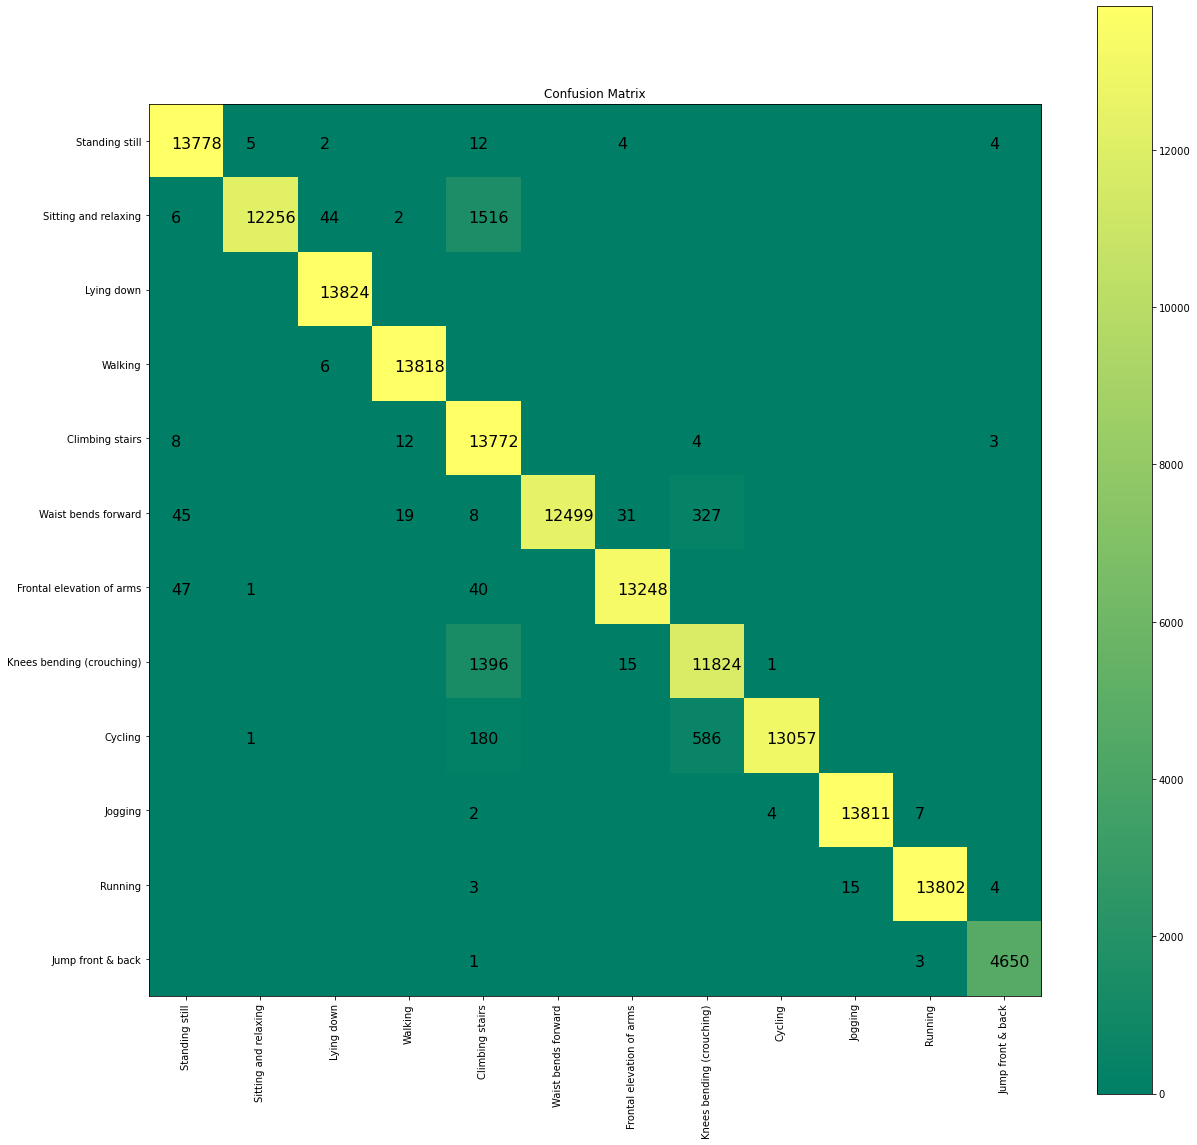

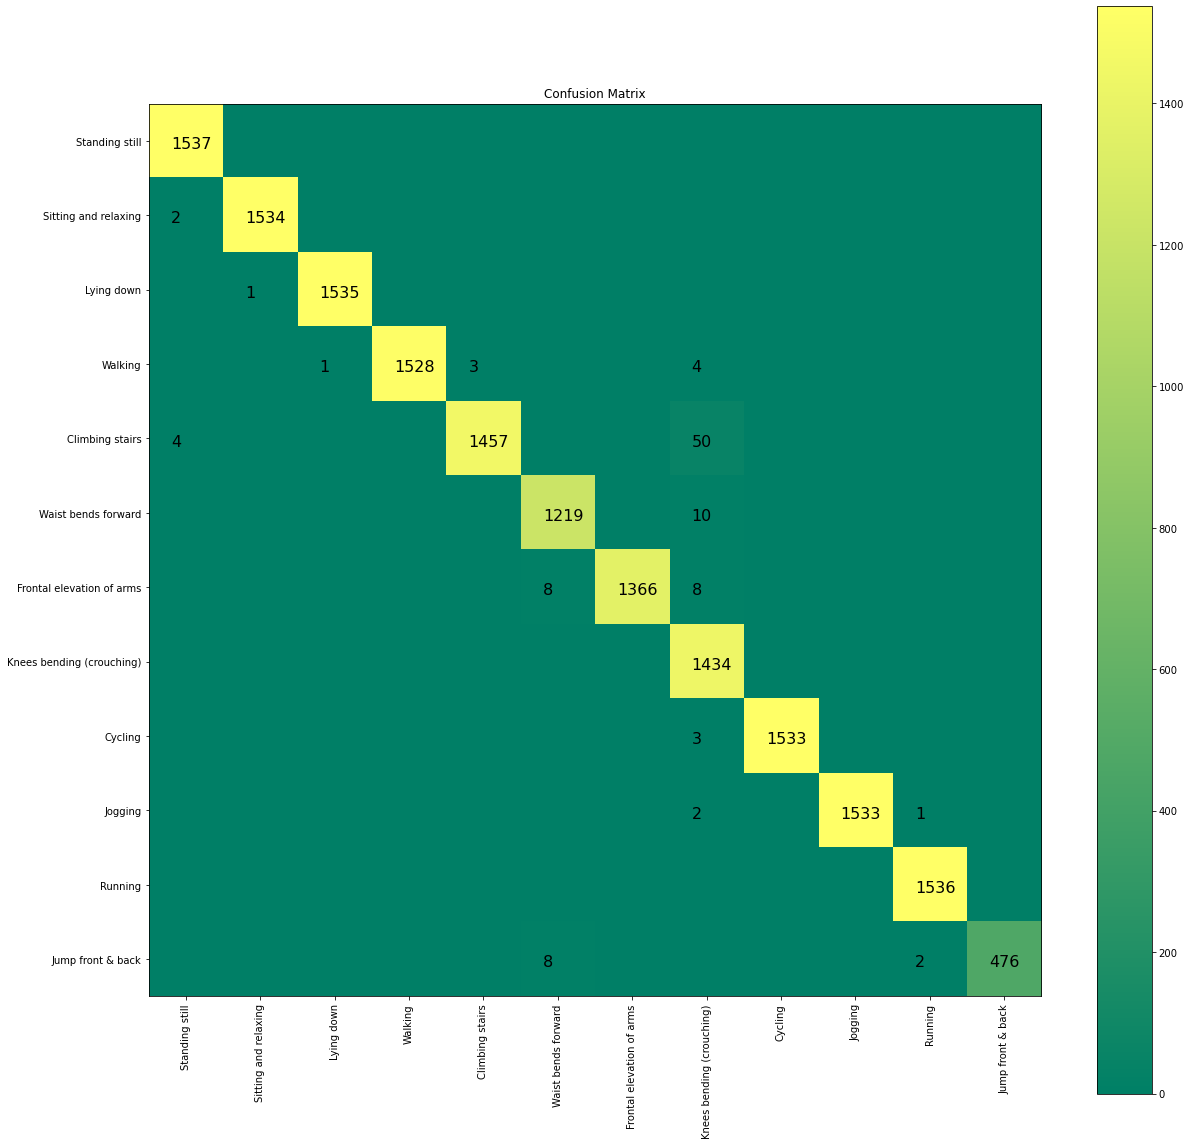

In [151]:
# get the confusion matrix and classification report

y_pred_train = RNN_model.predict(x_train)
print(conf_mat(y_train, y_pred_train))
print(clf_rep(y_train, y_pred_train))

y_pred_test = RNN_model.predict(x_test)
print(conf_mat(y_test, y_pred_test))
print(clf_rep(y_test, y_pred_test))

In [149]:
# save the model
RNN_model.save('CNN_LSTM_model_version_2.h5')

In [27]:
# reload the saved model
# but before it, the model needs to be initialized
new_model=Sequential()
new_model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(None,100,21))))
new_model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu')))
new_model.add(TimeDistributed(Dropout(0.5)))
new_model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
new_model.add(TimeDistributed(Flatten()))
new_model.add(LSTM(128, activation='relu'))
new_model.add(Dense(12, activation='sigmoid'))
new_model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
# without the saved model weights, see how it looks like to predict the test data
_, accuracy = new_model.evaluate(x_test, y_test_hot, batch_size=50, verbose=1)
print(accuracy)

16795/16795 [==============================] - 8s 499us/step
0.09615957128101958


In [30]:
# load the scaved model and run the test 
new_model.load_weights('CNN_LSTM_model_version_2.h5')
_, accuracy = new_model.evaluate(x_test, y_test_hot, batch_size=50, verbose=1)
print(accuracy)

16795/16795 [==============================] - 7s 438us/step
0.9936290563270782
